# Training MixtureOfSVGPExperts on the Motorcycle Data Set (with three experts)

This notebook is a basic example of configuring and training a Mixture of Gaussian Process Experts (using MixtureOfSVGPExperts) on the motorcycle dataset with three experts. The same approach can be used for any number of experts but the SVGPGatingNetworkBinary should be used when using only two experts. This is because only one gating function is needed and the gating network can be calculated in closed from, which is not the case generally. 

In [1]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from gpflow import default_float
from gpflow.utilities import print_summary

from mogpe.experts import SVGPExperts, SVGPExpert
from mogpe.gating_networks import SVGPGatingFunction, SVGPGatingNetworkMulti
from mogpe.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.training import training_tf_loop
from mogpe.helpers.plotter import Plotter1D

Let's start by configuring some of the model and training parameters.

In [2]:
num_inducing = 30
batch_size = 30
logging_epoch_freq = 500
num_epochs = 25000

Load the motorcycle dataset and plot it to see what we're dealing with.

Input data shape:  (133, 1)
Output data shape:  (133, 1)


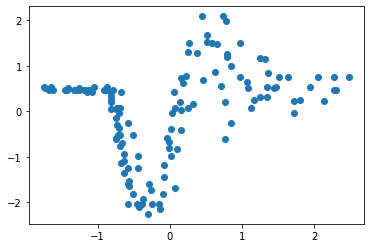

In [3]:
def load_mcycle_dataset(filename='../data/mcycle.csv'):
    df = pd.read_csv(filename, sep=',')
    X = pd.to_numeric(df['times']).to_numpy().reshape(-1, 1)
    Y = pd.to_numeric(df['accel']).to_numpy().reshape(-1, 1)

    X = tf.convert_to_tensor(X, dtype=default_float())
    Y = tf.convert_to_tensor(Y, dtype=default_float())
    print("Input data shape: ", X.shape)
    print("Output data shape: ", Y.shape)

    # standardise input
    mean_x, var_x = tf.nn.moments(X, axes=[0])
    mean_y, var_y = tf.nn.moments(Y, axes=[0])
    X = (X - mean_x) / tf.sqrt(var_x)
    Y = (Y - mean_y) / tf.sqrt(var_y)
    data = (X, Y)
    return data
data_file = '../data/mcycle.csv'
dataset = load_mcycle_dataset(filename=data_file)
X, Y = dataset
num_data = X.shape[0]
input_dim = X.shape[1]
output_dim = Y.shape[1]
plt.scatter(X, Y)

In order to initialie the MixtureOfSVGPExperts class for more than two experts we must pass it an instance of SVGPExperts and an instance of SVGPGatingNetworkMulti. Let's start by creating an instance of SVGPExperts. To do this we must first create three SVGPExpert instances and pass them as a list to SVGPExperts.

Let's create the first expert with a long lengthscale and a low noise variance that might roughly fit the data for x<0.7.

In [4]:
noise_var_1 = 0.001
kern_var_1 = 0.05
lengthscale_1 = 20.

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_1)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_1 = tf.convert_to_tensor([lengthscale_1] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_1))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_1 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)

Let's create a second expert also with a long lengthscale but a higher noise variance. This expert should roughly fit the data for x>-0.8.

In [5]:
noise_var_2 = 0.2
kern_var_2 = 0.005
lengthscale_2 = 15.0

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_2)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_2 = tf.convert_to_tensor([lengthscale_2] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_2))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_2 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)


Let's now create our third expert with a shorter lengthscale and high noise to model the data for -0.7<x<0.8.

In [6]:
noise_var_3 = 0.2
kern_var_3 = 14.
lengthscale_3 = 0.5

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_3)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list 
    lengthscale_3 = tf.convert_to_tensor([lengthscale_3] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_3))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_3 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)

We can now create an instance of SVGPExperts by passing our three experts as a list.

In [7]:
experts_list = [expert_1, expert_2, expert_3]
experts = SVGPExperts(experts_list)
print_summary(experts)

╒═══════════════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════════════════╕
│ name                                                              │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                 │
╞═══════════════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════════════════╡
│ SVGPExperts.experts_list[0].mean_function.c                       │ Parameter │ Identity         │         │ True        │ (1,)        │ float64 │ [0.]                  │
├───────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────┤
│ SVGPExperts.experts_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus         │         │ True        │ ()        

We now need to create an instance of SVGPGatingNetworkMulti which requires a list of at least three SVGPGatingFunction instances for its construction. Let's go ahead and create three gating functions (one for each expert).

In [8]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

lengthscale_1 = 0.5
kern_var_1 = 3.0
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 10
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale_1] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale, variance=kern_var_1))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function_1 = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)

In [9]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

lengthscale_2 = 0.5
kern_var_2 = 3.0
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 10
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale_2] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale, variance=kern_var_2))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function_2 = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)

In [10]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

lengthscale_3 = 0.5
kern_var_3 = 3.0
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 10
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale_3] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale, variance=kern_var_3))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function_3 = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)

We can now use our three gating functions to instantiate our gating network (SVGPGatingNetworkMulti).

In [11]:
gating_functions = [gating_function_1, gating_function_2, gating_function_3]
gating_network = SVGPGatingNetworkMulti(gating_functions)
print_summary(gating_network)

╒══════════════════════════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════════════╕
│ name                                                                                 │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value             │
╞══════════════════════════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════════════╡
│ SVGPGatingNetworkMulti.gating_function_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 3.0               │
├──────────────────────────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────┤
│ SVGPGatingNetworkMulti.gating_function_list[0].kernel.kernels[0].len

We now have all the components to construct our MixtureOfSVGPExperts model so let's go ahead and do it.

In [12]:
model = MixtureOfSVGPExperts(gating_network=gating_network, experts=experts, num_data=num_data)

We can use the Plotter1D class from visualization to plot our model before training.

Plotting gating network mixing probabilities...
Plotting experts y...
Plotting y...
mixing probs shape
(100, 1, 3)
experts dists shape
(100, 1, 3)


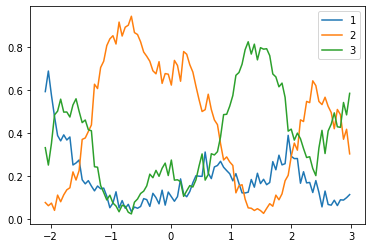

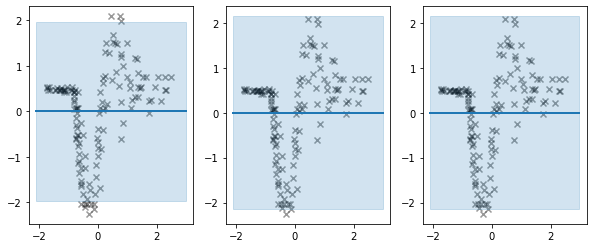

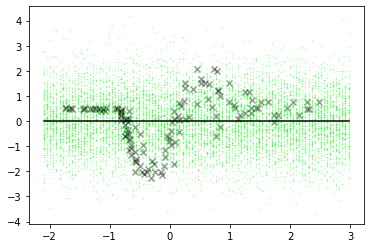

In [13]:
plotter = Plotter1D(model, X, Y)
plotter.plot_model()

We must now convert our numpy data set into a TensorFlow data set and set it up for stochastic optimisation by setting the batch size. We set drop_remainder=True to ensure the model receives the batch size.

In [14]:
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_data // 2
num_batches_per_epoch = num_data // batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = (train_dataset.repeat().prefetch(prefetch_size).shuffle(
    buffer_size=shuffle_buffer_size).batch(batch_size, drop_remainder=True))

We then use GPflow's training_loss_closure method to get our training loss.

In [15]:
training_loss = model.training_loss_closure(iter(train_dataset))

In mogpe.training.training_loops some training loops are defined. Here we use the simple training_tf_loop which runs the Adam optimizer on model with training_loss as the objective function. The loop does not use any TensorBoard monitoring.

In [16]:
training_tf_loop(model,
                 training_loss,
                 epochs=num_epochs,
                 num_batches_per_epoch=num_batches_per_epoch,
                 logging_epoch_freq=logging_epoch_freq)

Instructions for updating:
Use fn_output_signature instead
Mixing probs
(30, 1, 3)
Expected experts
(30, 1, 3)
Experts after product over output dims
(30, 1, 3)
Marginalised indicator variable
(30,)
Reduced sum over mini batch
()
Epoch 500: ELBO (train) 5966.59918056734
Epoch 1000: ELBO (train) 3907.1882662736334
Epoch 1500: ELBO (train) 2400.5730273923828
Epoch 2000: ELBO (train) 1476.9968699751394
Epoch 2500: ELBO (train) 833.8391113316446
Epoch 3000: ELBO (train) 523.1473194839764
Epoch 3500: ELBO (train) 356.91941412071094
Epoch 4000: ELBO (train) 179.03717627605172
Epoch 4500: ELBO (train) 177.47409767167198
Epoch 5000: ELBO (train) 150.72538932245644
Epoch 5500: ELBO (train) 93.28675106699404
Epoch 6000: ELBO (train) 47.65153685068491
Epoch 6500: ELBO (train) 57.466690456211
Epoch 7000: ELBO (train) -3.1249923979649488
Epoch 7500: ELBO (train) 55.88866611834099
Epoch 8000: ELBO (train) 68.94296134171992
Epoch 8500: ELBO (train) 62.0675387120432
Epoch 9000: ELBO (train) 61.6297918

Let's visualise what we have learned.

Plotting gating network mixing probabilities...
Plotting experts y...
Plotting y...
mixing probs shape
(100, 1, 3)
experts dists shape
(100, 1, 3)


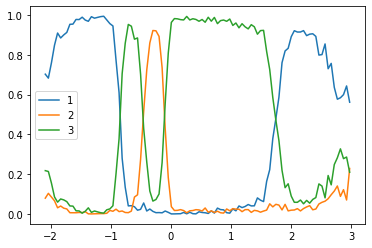

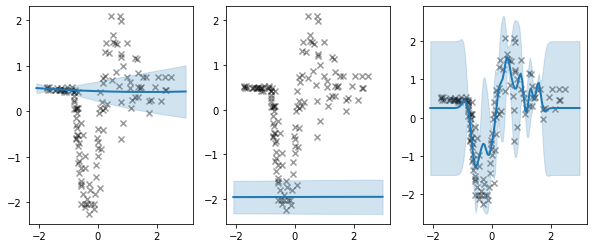

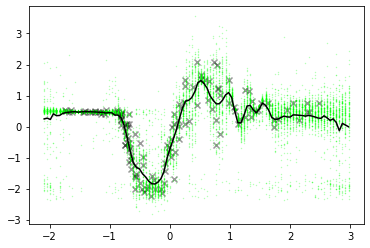

In [17]:
plotter.plot_model()